# AI6126 ACV P1 - Inference Notebook

In [1]:
nb_ver = 0.2
title = f'ai6126-p1-inference-v{nb_ver}'
print(title)

ai6126-p1-inference-v0.2


## Versioning and References

### Changelogs
+ V0.1 - Added inference codes

### References
+ None

## Load Inference Model

### Imports

In [2]:
import sys, os
import shutil
import time
import random
import numpy as np
import copy
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import config
from celeba_dataset import CelebaTestset
import models
from utils import Logger, ModelTimer

import seaborn as sns
sns.set()

# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

In [3]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

ISJUPYTER = False
if 'ipykernel' in sys.modules:
    ISJUPYTER = True
    # set the backend of matplotlib to the 'inline' backend
    %matplotlib inline
    config.disable_tqdm = False
    
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [4]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [5]:
def load_testset(print_info=True, albu_transforms = True):    
    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                   'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                   'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                   'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                   'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                   'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                   'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        
        test_transforms = transforms.Compose([
            transforms.Resize(178), #new
            transforms.CenterCrop(148),
            transforms.ToTensor(),
            normalize
        ])
        
    if albu_transforms:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                              std=(0.229, 0.224, 0.225))
        
        test_transforms = A.Compose([
            A.SmallestMaxSize(max_size=178),
            A.CenterCrop(height=168, width=168),
            normalize_A,
            ToTensorV2(),
        ]) 
        
    test_dataset = CelebaTestset(config.TESTSET_DIR, transform=test_transforms)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.test_batch, 
                                             pin_memory=True, shuffle=False, num_workers=config.dl_workers)
    if print_info:
        print(f"Testset size: {len(test_dataset)}")
        print(f"Number of Celebs: {len(test_dataset.celeba_ctr.keys())}")
        
    return test_dataset, test_loader, attribute_names

In [7]:
test_dataset, test_loader, attribute_names = load_testset()

Testset size: 13233
Number of Celebs: 5749


In [8]:
if False:
    real_batch = next(iter(test_loader))
    plt.figure(figsize=(12,12))
    plt.axis("off")
    plt.title("Private Testset Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Model Architecture Initialization

In [9]:
def create_model(arch, layers, device):
    print("=> creating model '{}'".format(config.arch))
    if arch.startswith('FaceAttrResNet'):
        model = models.__dict__[arch](resnet_layers = layers)
    elif arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[arch](resnet_layers = layers)
    elif arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[arch]()
    model = model.to(device)
    return model

In [10]:
def get_optimizer(model, opt_name=config.optimizer, no_bias_bn_decay=config.no_bias_bn_decay):
    weight_decay = config.weight_decay
    if no_bias_bn_decay: #bag of tricks paper
        parameters = add_weight_decay(model, weight_decay)
        weight_decay = 0.
    else:
        parameters = model.parameters()
    
    optimizer = None
    if opt_name == 'SGD':
        optimizer = torch.optim.SGD(parameters, config.lr,
                                momentum=config.momentum,
                                weight_decay=weight_decay)
    elif opt_name == 'Adam':
        optimizer = torch.optim.Adam(parameters, config.lr,
                            weight_decay=weight_decay)
    elif opt_name == 'AdamW':
        optimizer = torch.optim.AdamW(parameters, config.lr,
                            weight_decay=weight_decay)
    return optimizer

In [11]:
# def save_ckp(state, checkpoint_path):
#     print(f"=> saving checkpoint '{checkpoint_path}'")
#     torch.save(state, checkpoint_path)

In [12]:
def resume_checkpoint(device, ckp_logger_fname, ckp_resume=None):
    if not ckp_logger_fname:
        print("[W] Logger path not found.")
        raise

    start_epoch = 0
    best_prec1 = 0
    lr = config.lr
    
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming checkpoint: {ckp_resume}")
        checkpoint = torch.load(ckp_resume)
        
        try:
            total_time = checkpoint['total_time']
            model_timer = ModelTimer(total_time)
            print(f"=> model trained time: {model_timer}")
        except:
            print(f"=> old model")
            model_timer = ModelTimer()
        best_prec1 = checkpoint['best_prec1']
        print(f"=> model best val: {best_prec1}")
        
        start_epoch = checkpoint['epoch']
        print(f"=> model epoch: {start_epoch}")
        lr = checkpoint['lr']

        print(f"=> resuming model: {checkpoint['arch']}")
        model = create_model(checkpoint['arch'].split('_')[0], 
                             int(checkpoint['arch'].split('_')[1]), 
                             device)
        model.load_state_dict(checkpoint['state_dict'])
        
        print(f"=> resuming optimizer: {checkpoint['opt_name']}")
        bias_decay = True
        if checkpoint['bias_decay']:
            bias_decay = checkpoint['bias_decay']
            
        optimizer = get_optimizer(model, checkpoint['opt_name'], bias_decay)
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer'])
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
        
    else:
        print(f"=> restarting training: {ckp_resume}")
        model_timer = ModelTimer()
        model = create_model(config.arch, config.pt_layers, device)
        optimizer = get_optimizer(model)
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
              
    return best_prec1, model_timer, lr, start_epoch, logger, model, optimizer

def format_checkpoint(modelname, opt_name, bias_decay=False, ckp_resume=None):
    best_prec1 = 0

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        checkpoint = torch.load(ckp_resume)
        print(checkpoint['arch'])
        try:
            total_time = checkpoint['total_time']
        except:
            total_time = 0
        is_best=False
        state = {
            'epoch': checkpoint['epoch'],
            'arch': modelname,
            'state_dict': checkpoint['state_dict'],
            'best_prec1': checkpoint['best_prec1'],
            'opt_name': opt_name,
            'optimizer' : checkpoint['optimizer'],
            'lr': checkpoint['lr'],
            'total_time': total_time,
            'bias_decay': bias_decay
        }
        torch.save(state, ckp_resume)
        
    else:
        raise

In [15]:
format_checkpoint('FaceAttrResNet_50', 'SGD', False, ckp_resume="inf\\FaceAttrResNet50_42_s0e80_tb128_vb128_FL_SGD_38_lr0.01_wd0.0001_ReduceLROnPlateau\\20201016_014917\\model_best.pth.tar")

=> resuming model: inf\FaceAttrResNet50_42_s0e80_tb128_vb128_FL_SGD_38_lr0.01_wd0.0001_ReduceLROnPlateau\20201016_014917\model_best.pth.tar
FaceAttrResNet50


In [16]:
def load_inference_model(device, ckp_resume):
    if not (ckp_resume and os.path.isfile(ckp_resume)):
        print("[W] Checkpoint not found for inference.")
        raise 
    
    print(f"=> loading checkpoint: {ckp_resume}")
    checkpoint = torch.load(ckp_resume)
    try:
        total_time = checkpoint['total_time']
        model_timer = ModelTimer(total_time)
        print(f"=> model trained time: {model_timer}")
    except:
        print(f"=> old model")
    best_prec1 = checkpoint['best_prec1']
    print(f"=> model best val: {best_prec1}")

    print(f"=> resuming model: {checkpoint['arch']}")
    model = create_model(checkpoint['arch'].split('_')[0], 
                         int(checkpoint['arch'].split('_')[1]), 
                         device)
    model.load_state_dict(checkpoint['state_dict'])
              
    return best_prec1, model

config.INFERENCE_DIR = 'inf'
lfile = 'model_best.pth.tar'
inf_models = {}
for dirt in os.listdir(config.INFERENCE_DIR):
    dirpath = os.path.join(config.INFERENCE_DIR, dirt)
    for run in os.listdir(dirpath):
        runpath = os.path.join(dirpath, run)
        if os.path.isdir(runpath): 
            for filename in os.listdir(runpath):
                print(filename, lfile)
                if filename == lfile:
                    print("h")
                    best_prec1, model = load_inference_model(device, os.path.join(runpath,lfile))
                    inf_models[dirt] = (model, best_prec1)
                
print(f'==> {len(inf_models)} inference model(s) loaded.')
print(f'==> {inf_models.keys()}')

ai6126-project1-colab-v1.2.html model_best.pth.tar
checkpoint.pth.tar model_best.pth.tar
log.txt model_best.pth.tar
logs.eps model_best.pth.tar
losses.jpg model_best.pth.tar
model_best.pth.tar model_best.pth.tar
h
=> loading checkpoint: inf\FaceAttrResNet50_42_s0e80_tb128_vb128_FL_SGD_38_lr0.01_wd0.0001_ReduceLROnPlateau\20201016_014917\model_best.pth.tar
=> model trained time: 08:38:17
=> model best val: 92.00583882616266
=> resuming model: FaceAttrResNet_50
=> creating model 'FaceAttrResNet'
==> 1 inference model(s) loaded.
==> dict_keys(['FaceAttrResNet50_42_s0e80_tb128_vb128_FL_SGD_38_lr0.01_wd0.0001_ReduceLROnPlateau'])


## Make Predictions

In [17]:
selected_model = "FaceAttrResNet50_42_s0e80_tb128_vb128_FL_SGD_38_lr0.01_wd0.0001_ReduceLROnPlateau"
p_model, p_model_acc = inf_models[selected_model]
print(f"=> best model val: {p_model_acc}")

=> best model val: 92.00583882616266


In [18]:
maxk = 1
preds = pd.DataFrame(index=test_dataset.imagenames, columns=attribute_names)
p_model.eval()

for X, names in tqdm(test_loader, disable=False):
    inputs = X.to(device, non_blocking=True)

    top_k_preds = []
    with torch.no_grad():
        outputs = p_model(inputs) # 40, BS
    
        for attr_scores in outputs:
            _, attr_preds = attr_scores.topk(maxk, 1, True, True)
            top_k_preds.append(attr_preds.t())
            
    all_preds = torch.cat(top_k_preds, dim=0) 

    all_preds = all_preds.permute(1,0).cpu()
    all_preds[all_preds == 0] = -1
    for j in range(len(names)):
        preds.loc[names[j], :] = all_preds[j]
preds

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:38<00:00,  2.73it/s]


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
Aaron_Eckhart_0001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Aaron_Guiel_0001.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
Aaron_Patterson_0001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Aaron_Peirsol_0001.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
Aaron_Peirsol_0002.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zorica_Radovic_0001.jpg,-1,-1,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Zulfiqar_Ahmed_0001.jpg,-1,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Zumrati_Juma_0001.jpg,-1,-1,-1,-1,-1,-1,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
Zurab_Tsereteli_0001.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


In [19]:
run_dir = os.path.join(config.INFERENCE_DIR, selected_model)
pfile = os.path.join(run_dir, "predictions.csv")
preds.to_csv(pfile, index=True)

### Analyze Predictions

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['Julianna_Margulies_0002.jpg'], dtype='object')


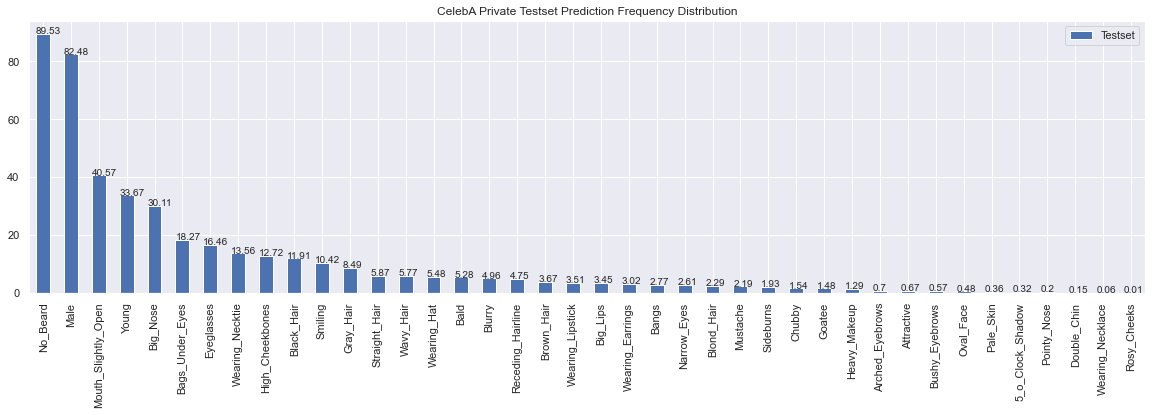

In [25]:
stat_df = pd.DataFrame(index = attribute_names)
stat_df.loc[:,'Testset'] = (preds.iloc[:,:] == 1).mean(axis=0)*100
stat_df = stat_df.sort_values('Testset', ascending=False)
fig, ax = plt.subplots()
stat_df.plot(title='CelebA Private Testset Prediction Frequency Distribution', 
             kind='bar', figsize=(20, 5), ax=ax)
for p in ax.patches:
    value = round(p.get_height(),2)
    ax.annotate(str(value), xy=(p.get_x(), p.get_height()))
print(preds[(preds['Young']==1) & (preds['Gray_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Mustache']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Goatee']==1)].index)
print(preds[(preds['Gray_Hair']==1) & (preds['Blond_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['No_Beard']==-1)].index)

Index([], dtype='object')

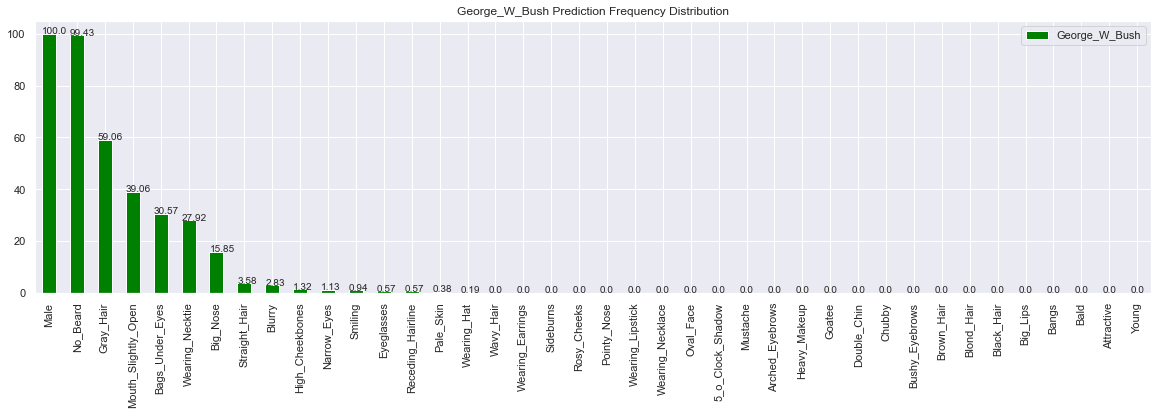

In [27]:
# George_W_Bush Predictions
celeb_preds = preds[preds.index.str.contains('George_W_Bush')]
celeb_stat = pd.DataFrame(index = attribute_names)
celeb_stat.loc[:,'George_W_Bush'] = (celeb_preds.iloc[:,:] == 1).mean(axis=0)*100
celeb_stat = celeb_stat.sort_values('George_W_Bush', ascending=False)
fig, ax = plt.subplots()
celeb_stat.plot(title='George_W_Bush Prediction Frequency Distribution', 
             kind='bar', figsize=(20, 5), color='green', ax=ax)
for p in ax.patches:
    value = round(p.get_height(),2)
    ax.annotate(str(value), xy=(p.get_x(), p.get_height()))
celeb_preds[(celeb_preds['Young']==1) & (celeb_preds['Gray_Hair']==1)].index
celeb_preds[(celeb_preds['Male']==0) & (celeb_preds['Mustache']==1)].index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


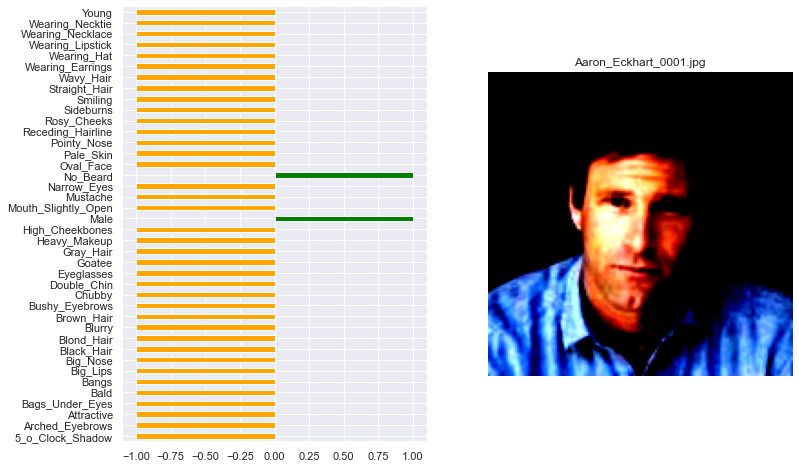

In [34]:
def plot_prediction_with_image(preds, index):
    p_attrs = preds.iloc[index,:]
    p_img = preds.index[index]
    fig, (ax, ax2) = plt.subplots(ncols=2)
    my_color=np.where(p_attrs>=0, 'green', 'orange')
    p_attrs.plot(kind='barh',ax=ax, figsize=(12, 8), color=my_color)
    
    s_img = test_dataset[index][0].permute(1, 2, 0)
    ax2.imshow(s_img)
    ax2.set_axis_off()
    plt.title(p_img)
    plt.show()
    
plot_prediction_with_image(preds, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


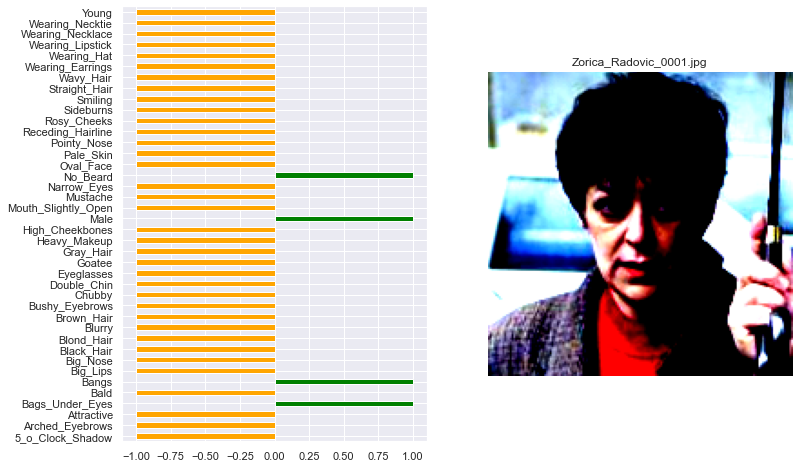

In [35]:
plot_prediction_with_image(preds, -5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


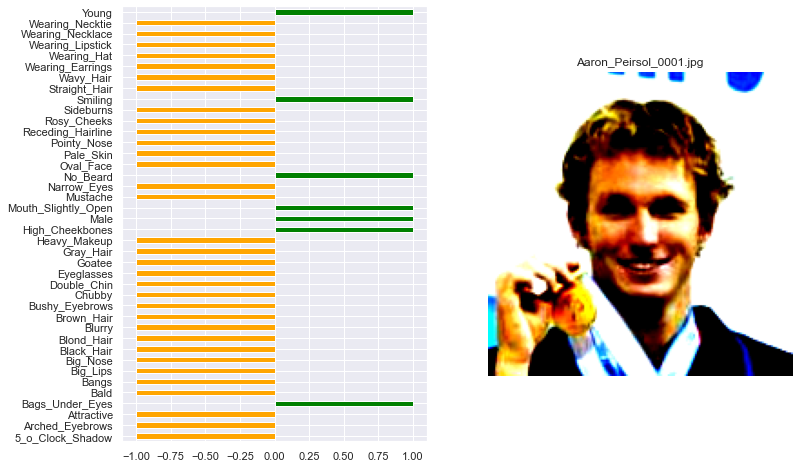

In [36]:
plot_prediction_with_image(preds, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


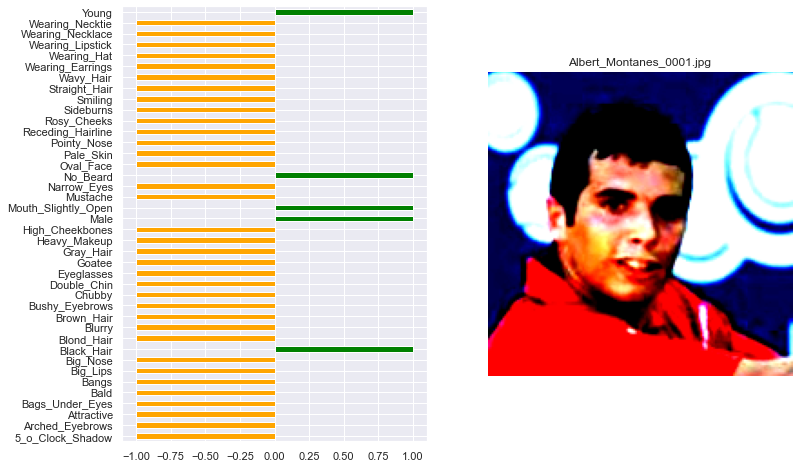

In [48]:
plot_prediction_with_image(preds, 201)

In [37]:
if ISJUPYTER:
    # Wait for notebook to save
    %autosave 1
    time.sleep(121)
    %autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [38]:
def backup_everything(run_dir, title, backup_nb=ISJUPYTER):
    if backup_nb:
        print(f"=> backing up notebook... ")
        # backup notebook html
        nb_name = title + '.ipynb'
        html_name = title + '.html'
        save_name = os.path.join(run_dir, html_name)
        !jupyter nbconvert --to html $nb_name
        shutil.move(html_name, save_name)
    
backup_everything(run_dir, title, backup_nb=ISJUPYTER)

=> backing up notebook... 


[NbConvertApp] Converting notebook ai6126-p1-inference-v0.2.ipynb to html
[NbConvertApp] Writing 1260927 bytes to ai6126-p1-inference-v0.2.html
